In [1]:
%matplotlib inline
import pandas as pd

In [19]:
import seaborn as sns
from matplotlib import pyplot
from scipy.stats import pearsonr
from datetime import timedelta
import numpy as np 
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import preprocessing

## Load Data

In [3]:
df_rides = pd.read_csv('rides.csv')
df_rides['created_on_hour'] = pd.to_datetime(df_rides['created_on_hour'])
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


## Data Exploration

In [4]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()

,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


### Task #1

Plot the rides overtime on a daily level. 
Is there any trend?

#### We can see that the number of rides increase over time.

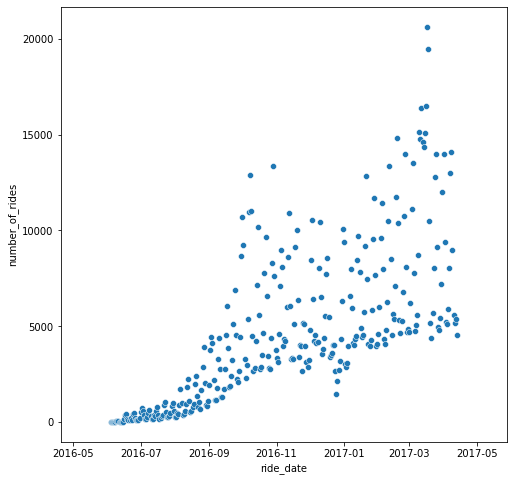

In [5]:
df_rides['ride_date'] = df_rides['created_on_hour'].dt.date

df_daily_rides = df_rides.groupby('ride_date')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'number_of_rides'})

_, ax = pyplot.subplots(figsize=(8, 8))

sns.scatterplot(ax=ax, data=df_daily_rides, x="ride_date", y="number_of_rides")

### Task #2

Plot a ride distance histogram.
What is the distribution? is it normal?

#### the distribution does not look normal, I think its closer to log normal.

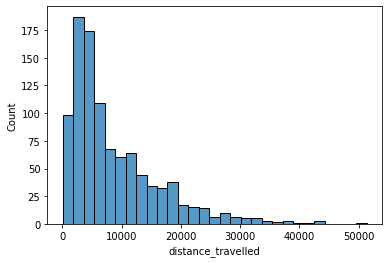

In [6]:
ax = sns.histplot(x="distance_travelled", data=df_rides.sample(1000))

## Preprocessing

In [7]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Task #3

You have time features in the df_times dataframe. 
Merge this dataframe with the hourly rides dataframe, so you can use those features later.

In [8]:
df_hourly_rides = pd.merge(df_times, df_hourly_rides, left_on='datetime', right_on='created_on_hour')

### Task #4

We would like to add a lag feature, which retrieves the amount of rides taken at the same exact hour last week. 
Please implement this feature.
What is the correlation between current and last week's rides?

In [9]:

df_last_week_hourly_rides = df_hourly_rides[['rides', 'created_on_hour']].rename(columns = 
                                                   {'rides': 'number_of_rides_on_same_hour_last_week' })

df_last_week_hourly_rides['last_week_of_created_on_hour'] = df_last_week_hourly_rides['created_on_hour'] - timedelta(days = 7)

df_last_week_hourly_rides.drop("created_on_hour", axis=1, inplace = True)


df_hourly_rides = pd.merge(df_hourly_rides, 
              df_last_week_hourly_rides, left_on='created_on_hour', 
                                     right_on = 'last_week_of_created_on_hour',
                          how = 'left')

df_hourly_rides.drop("last_week_of_created_on_hour", axis=1, inplace = True)




In [10]:
#the first week will not have the number of rides from last week so I am filtering those rows.

df_hourly_rides_with_valid_last_week = df_hourly_rides[df_hourly_rides['number_of_rides_on_same_hour_last_week'].notnull()]

pearsonr(df_hourly_rides_with_valid_last_week['rides'], df_hourly_rides_with_valid_last_week['number_of_rides_on_same_hour_last_week'])[0]

0.8326306550260205

In [251]:
df_hourly_rides.sample(1)

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour,created_on_hour,rides,number_of_rides_on_same_hour_last_week
477,2016-07-02 12:00:00,5,7,2,2016,26,184,False,None,12,2016-07-02 12:00:00,21,17.0


## Model

In [11]:
from sklearn.metrics import mean_absolute_error

### Task #5

We would like to predict how many rides will occur every hour.

As a first step, propose a simple baseline and measure its MAE (mean absolute error)

### Baseline - LinearRegression model 

In [12]:
df_hourly_rides = df_hourly_rides.where(pd.notnull(df_hourly_rides), None)


train = df_hourly_rides[df_hourly_rides.datetime < '2017-03-30 00:00:00']
test = df_hourly_rides[(df_hourly_rides.datetime >= '2017-03-30 00:00:00') & (df_hourly_rides.datetime < '2017-04-13 00:00:00')]

In [13]:
np.max(train['datetime']), np.min(test['datetime'])

(Timestamp('2017-03-29 23:00:00'), Timestamp('2017-03-30 00:00:00'))

In [15]:
def preprocessing_df(df: pd.DataFrame):
    df['us_holiday_type'] = df['us_holiday_type'].apply(lambda x: 'NA' if x is None else x)
    df['number_of_rides_on_same_hour_last_week'] = df['number_of_rides_on_same_hour_last_week'].apply(lambda x: -1 if x is None else x)

    

In [16]:
preprocessing_df(train)
preprocessing_df(test)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
us_holiday_type_encoder = preprocessing.LabelEncoder()
us_holiday_types =  pd.unique(train['us_holiday_type']).tolist()
us_holiday_type_encoder.fit(us_holiday_types)

LabelEncoder()

In [21]:
train['us_holiday_type_id'] = train['us_holiday_type'].apply(lambda holiday_type: us_holiday_type_encoder.transform([holiday_type])[0])

test['us_holiday_type_id'] = test['us_holiday_type'].apply(lambda holiday_type: us_holiday_type_encoder.transform([holiday_type])[0])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
FEATURES_COLUMNS = ['weekday', 'month', 'day', 'year', 'weekofyear',
                    'dayofyear', 'us_holiday', 'us_holiday_type_id',  
                    'hour', 'number_of_rides_on_same_hour_last_week']

df_train_features = train[FEATURES_COLUMNS]

features_scaler = preprocessing.MinMaxScaler()
X = features_scaler.fit_transform(df_train_features)

y = train['rides'].tolist()

lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
df_test_features = test[FEATURES_COLUMNS]
X = features_scaler.transform(df_test_features)
y = test['rides'].tolist()
y_hat = lr.predict(X)
mean_absolute_error(y, y_hat)

149.95649858866614

### Task #6

Now let's create a model and calculate its performance.

Is it better than the baseline?

In [24]:

df_train_features = train[FEATURES_COLUMNS]
train_y = train['rides'].tolist()


df_test_features = test[FEATURES_COLUMNS]
test_y = test['rides'].tolist()

model = xgb.XGBRegressor(max_depth = 5)
model.fit(df_train_features, train_y)



[22:55:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [25]:
test_y_hat = model.predict(df_test_features)
mean_absolute_error(test_y, test_y_hat)

114.1716548374721

### Task #7

You've been offered to purchase an extension of this historical dataset going further into the past. In order to decide whether it is worthwhile, you need to estimate if there's a potential to improve the model given this data.

What is your estimation and why?

#### My estimation is that purchasing more data has potential to improve the model since
#### rides have seasonality behavior that the model can learn with more trainning data.